In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# dias_estada_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")

canasta_hospitalizados_grd = pd.read_excel(
    "../data/processed/canasta_procedimientos_hospitalizados.xlsx"
)

Primero se quiere hacer un forecasting total de los egresos (sin desglose por diagnostico),
y tambien de los procedimientos necesarios totales


In [4]:
DIAGNOSTICO = "C341"

In [5]:
resumen_egresos_totales = (
    egresos_torax.query("DIAG1 == @DIAGNOSTICO and ANO_EGRESO == 2019")
    .groupby(["ANO_EGRESO"])["n_egresos"]
    .sum()
    .reset_index()
)
resumen_procedimientos_totales = canasta_hospitalizados_grd.query(
    "DIAGNOSTICO1 == 'C34.1' and ANIO_EGRESO == 2019"
)

In [6]:
EGRESOS_AUMENTADOS = 300
EGRESOS_2019 = resumen_egresos_totales.n_egresos.iloc[0]
AUMENTO_PROPORCIONAL = EGRESOS_AUMENTADOS / EGRESOS_2019

In [7]:
procedimientos_aumentados = resumen_procedimientos_totales.copy()
COLS_A_AUMENTAR = ["cantidad_procedimientos", "cantidad_pacientes_distintos"]

procedimientos_aumentados[COLS_A_AUMENTAR] = (
    procedimientos_aumentados[COLS_A_AUMENTAR] * AUMENTO_PROPORCIONAL
)

# 1. Forecasting

En este cuadernilllo se quiere predecir la cantidad de egresos hospitalarios que tendra
el Hospital del Torax a lo largo del tiempo. Ademas, se quire saber cuantos insumos se necesitaran
para atender tales casos.


In [8]:
resumen_egresos = egresos_torax.groupby(egresos_torax["FECHA_EGRESO"])["n_egresos"].sum().to_frame()

<Axes: xlabel='FECHA_EGRESO'>

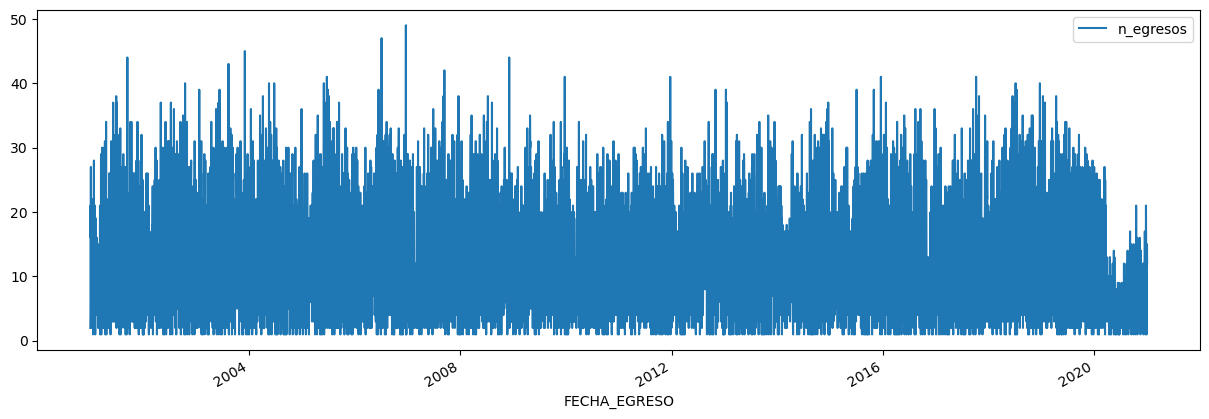

In [9]:
resumen_egresos.plot(figsize=(15, 5))

## Separacion en Train/Test


In [10]:
train = resumen_egresos[resumen_egresos.index < "01-01-2017"]
test = resumen_egresos[resumen_egresos.index >= "01-01-2017"]

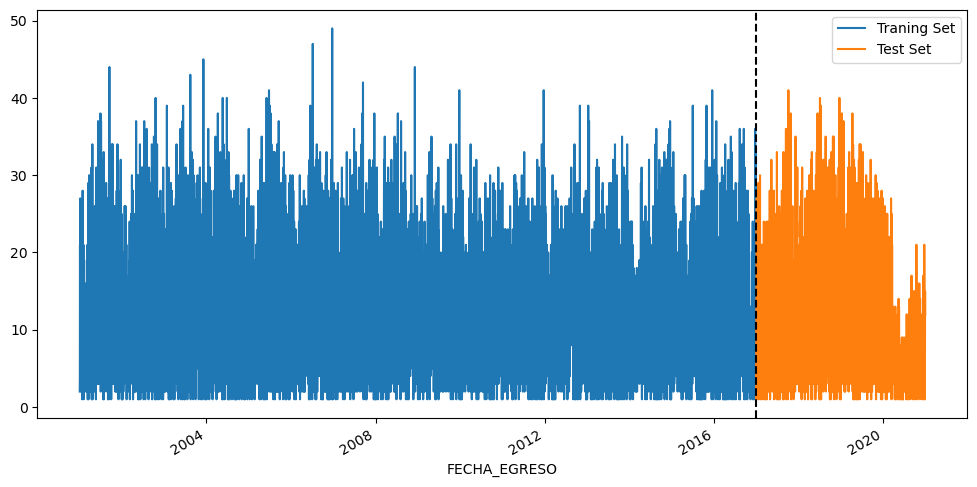

In [11]:
fig, axis = plt.subplots(1, 1, figsize=(12, 6))
train.plot(ax=axis, label="Traning")
test.plot(ax=axis, label="Test")
axis.axvline("01-01-2017", color="black", ls="--")
axis.legend(["Traning Set", "Test Set"])

In [12]:
resumen_egresos = build_features.create_features_datetime_index(resumen_egresos)

In [13]:
resumen_egresos

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays
FECHA_EGRESO,,,,,,,,,
2001-01-01,2,0,1,1,1,2001,1,0,1
2001-01-02,4,1,1,2,1,2001,2,0,0
2001-01-03,21,2,1,3,1,2001,3,0,0
2001-01-04,16,3,1,4,1,2001,4,0,0
2001-01-05,27,4,1,5,1,2001,5,0,0
...,...,...,...,...,...,...,...,...,...
2020-12-27,1,6,4,27,12,2020,362,1,0
2020-12-28,4,0,4,28,12,2020,363,0,0
2020-12-29,7,1,4,29,12,2020,364,0,0


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: 

<Axes: xlabel='dayofweek', ylabel='n_egresos'>

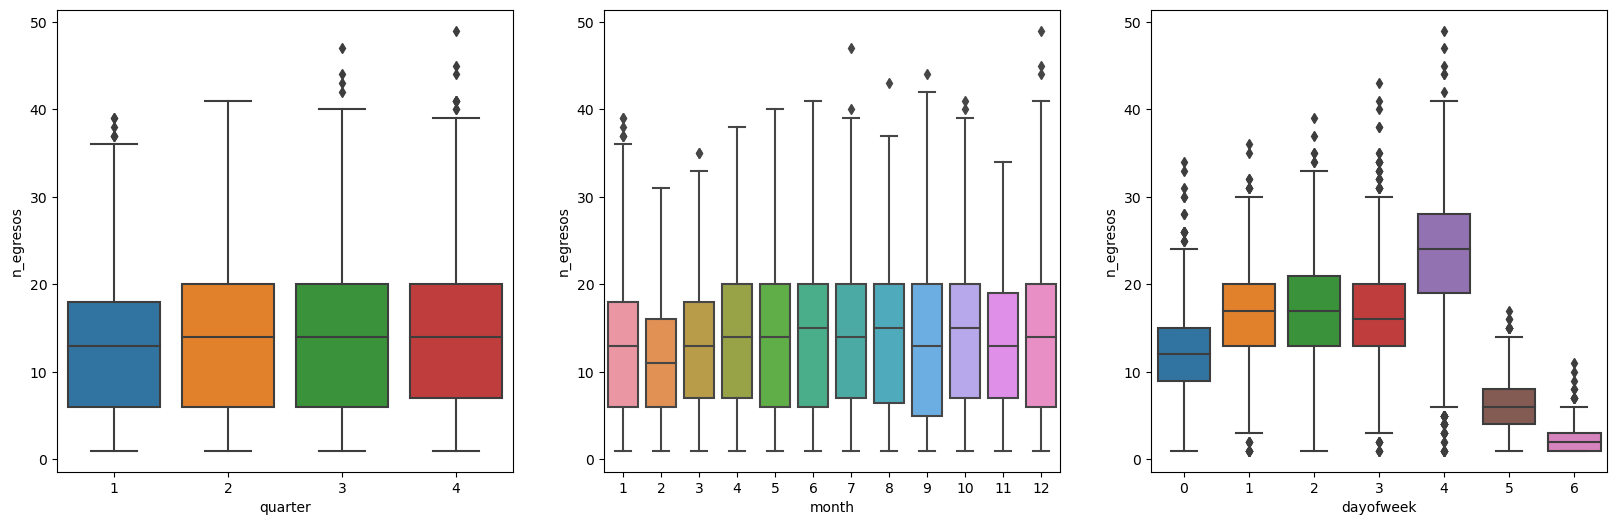

In [14]:
fig, axis = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=resumen_egresos, x="quarter", y="n_egresos", ax=axis[0])
sns.boxplot(data=resumen_egresos, x="month", y="n_egresos", ax=axis[1])
sns.boxplot(data=resumen_egresos, x="dayofweek", y="n_egresos", ax=axis[2])

Con estos resultados se puede observar que en el primer cuatrimestre existe una menor cantidad
de egresos hospitalarios. Ademas, se aprecia que la distribucion de egresos por mes es similar
a lo largo de cada mes. Sin embargo, es posible apreciar que en el mes de febrero existe una
baja en el promedio de egresos.

Dentro de una semana, se puede ver que la cantidad de egresos va aumentando durante la semana
laboral, teniendo un máximo los viernes. Además, se aprecia que los fin de semanas se tiene la
menor cantidad de egresos.


# 3. Creacion de Modelo


In [15]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [16]:
train = build_features.create_features_datetime_index(train)
test = build_features.create_features_datetime_index(test)

FEATURES = ["dayofweek", "quarter", "month", "year", "dayofyear", "weekend", "holidays"]
TARGET = "n_egresos"

In [17]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

In [19]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:15.65151	validation_1-rmse:15.08070
[100]	validation_0-rmse:7.14054	validation_1-rmse:7.66349


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:4.90596	validation_1-rmse:5.92325
[300]	validation_0-rmse:4.41380	validation_1-rmse:5.65957
[400]	validation_0-rmse:4.25977	validation_1-rmse:5.62937
[466]	validation_0-rmse:4.19621	validation_1-rmse:5.64356


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance


In [20]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
)

<Axes: >

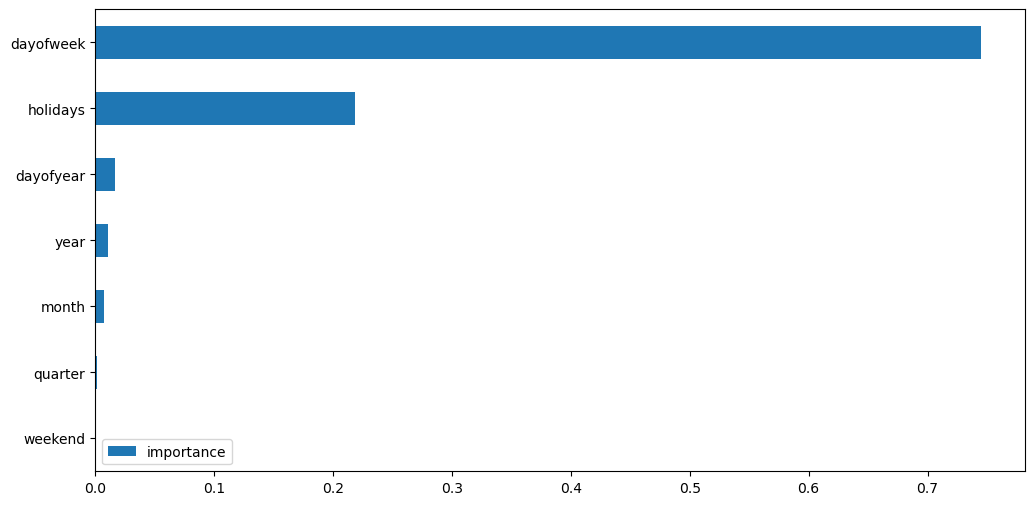

In [21]:
feature_importance.sort_values("importance").plot(kind="barh")

Estos resultados indican que el dia de la semana es altamente importante para predecir los egresos
hospitalarios!. Además, la variable indicadora de feriados también es altamente relevante.


## Prediccion en Test


In [22]:
test["prediction"] = reg.predict(X_test)

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

In [23]:
resumen_egresos = resumen_egresos.merge(
    test["prediction"], how="left", left_index=True, right_index=True
)

Text(0.5, 1.0, 'Data Real vs Prediccion de Egresos Hospitalarios INT')

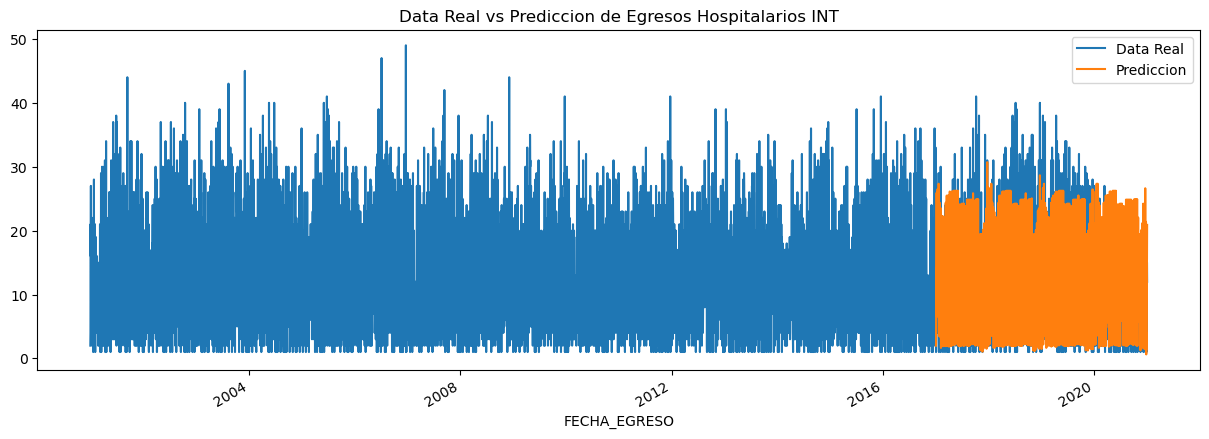

In [24]:
ax = resumen_egresos["n_egresos"].plot(figsize=(15, 5))
resumen_egresos["prediction"].plot(ax=ax)
plt.legend(["Data Real", "Prediccion"])
ax.set_title("Data Real vs Prediccion de Egresos Hospitalarios INT")

In [25]:
filtro_semana = resumen_egresos[
    (resumen_egresos.index >= "05-01-2017") & (resumen_egresos.index <= "07-01-2017")
]

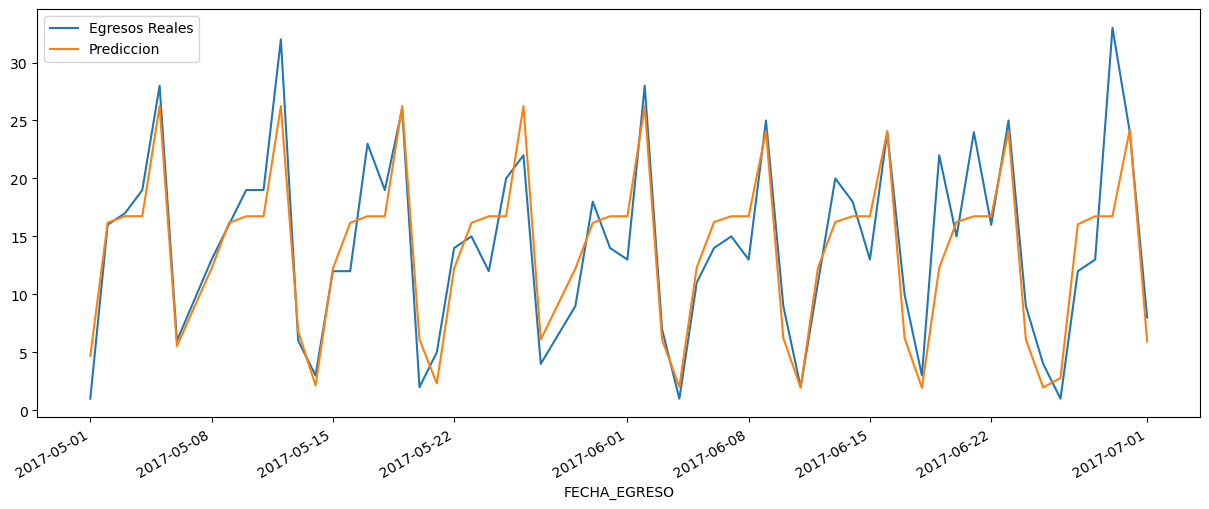

In [26]:
fig, axis = plt.subplots(figsize=(15, 6))
filtro_semana["n_egresos"].plot(ax=axis)
filtro_semana["prediction"].plot(ax=axis)
plt.legend(["Egresos Reales", "Prediccion"])

Y aca se puede ver la cantidad de egresos en la primera semana de Mayo de 2017.


In [27]:
rmse_modelo = np.sqrt(mean_squared_error(test["n_egresos"], test["prediction"]))
print(f"El modelo tiene un RMSE de: {rmse_modelo:0f} egresos")

El modelo tiene un RMSE de: 5.628271 egresos


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is depreca

In [28]:
test["error"] = np.abs(test["n_egresos"] - test["prediction"])

In [29]:
test.sort_values("error", ascending=False).head(5)

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,error
FECHA_EGRESO,,,,,,,,,,,
2017-10-26,38,3,4,26,10,2017,299,0,0,16.367750,21.632250
2020-06-19,3,4,2,19,6,2020,171,0,0,24.084307,21.084307
2020-06-05,3,4,2,5,6,2020,157,0,0,24.084307,21.084307
2020-05-22,6,4,2,22,5,2020,143,0,0,26.244677,20.244677
2020-10-02,5,4,4,2,10,2020,276,0,0,24.896091,19.896091


In [30]:
test.sort_values("error", ascending=False).tail(5)

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,error
FECHA_EGRESO,,,,,,,,,,,
2019-08-04,2,6,3,4,8,2019,216,1,0,2.016498,0.016498
2019-10-26,6,5,4,26,10,2019,299,1,0,6.016024,0.016024
2020-10-18,2,6,4,18,10,2020,292,1,0,2.010057,0.010057
2017-10-22,2,6,4,22,10,2017,295,1,0,2.010057,0.010057
2018-10-21,2,6,4,21,10,2018,294,1,0,2.010057,0.010057


<Axes: >

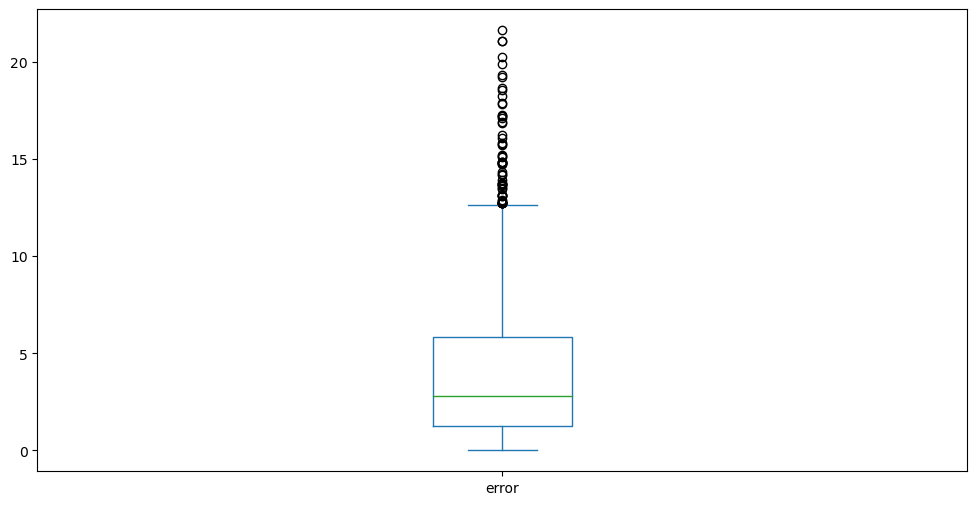

In [31]:
test["error"].plot(kind="box")

## Mejorando el modelo

Observamos que existen predicciones que tuvieron un error de hasta 26 egresos hospitalarios. Debido
a lo anterior, es necesario mejorar el modelo. Una de las formas mas efectivas de mejorar
el modelo es **remover outliers**!


## Remover Outliers

Se sabe que 2020 es un anio con grandes problemas (pandemia). Ademas, es posible observar una
disminucion significativa en la cantidad de egresos. Debido a esto, es necesario filtrar estos
anios.


In [32]:
resumen_egresos = resumen_egresos[resumen_egresos.index < "2020-01-01"]

Otra de las grandes mejores es hacer una validacion cruzada con las series de tiempo.


## Validacion Cruzada


In [33]:
from sklearn.model_selection import TimeSeriesSplit

In [34]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)
resumen_egresos = resumen_egresos.sort_index()

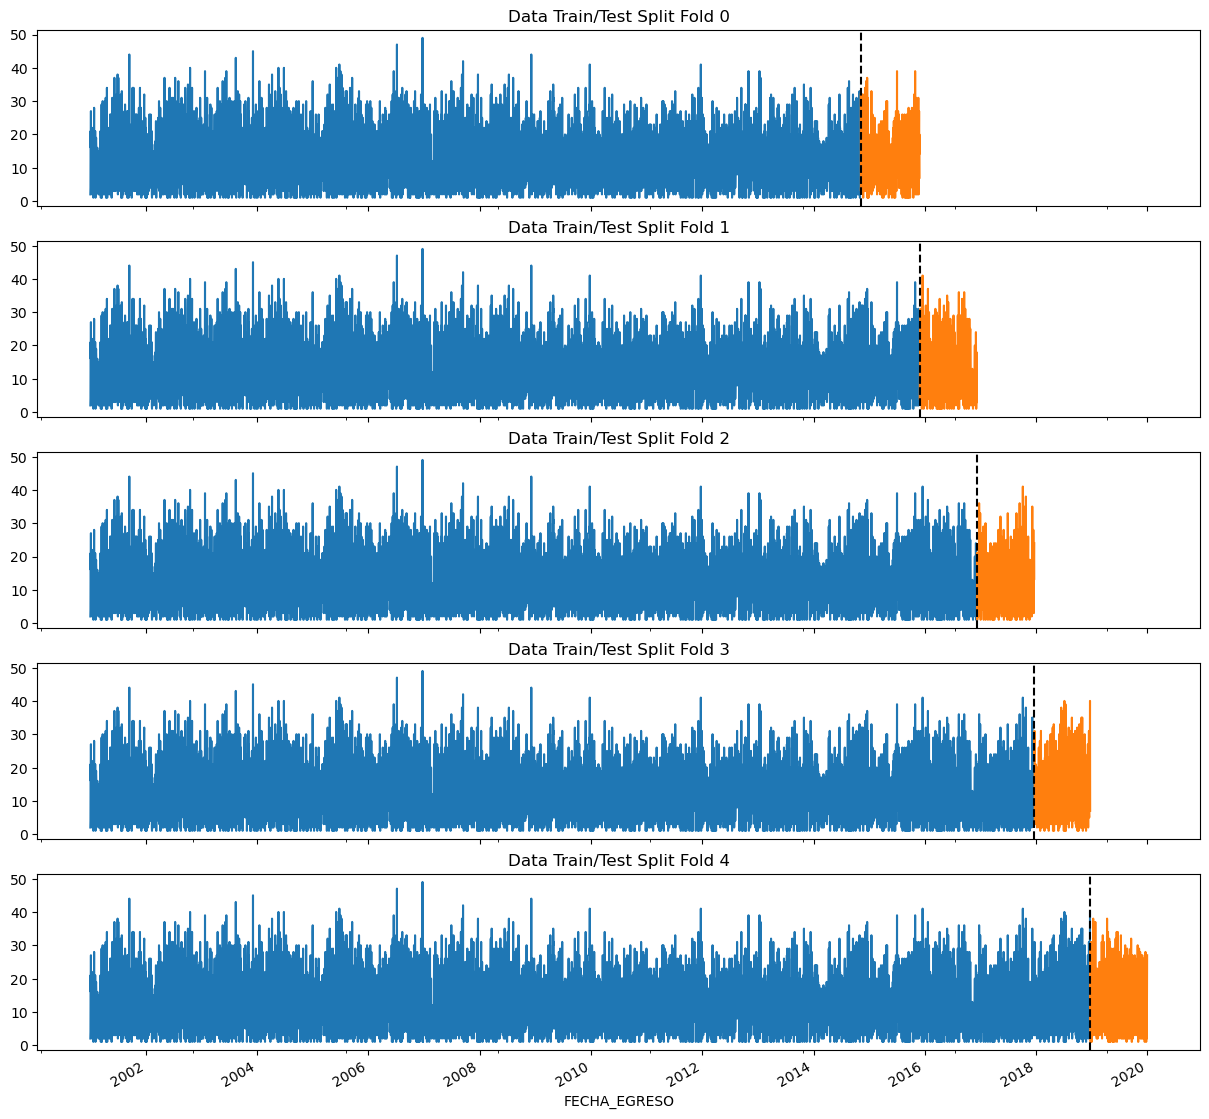

In [35]:
fig, axis = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(resumen_egresos):
    train = resumen_egresos.iloc[train_idx]
    test = resumen_egresos.iloc[val_idx]

    train["n_egresos"].plot(
        ax=axis[fold], label="Training", title=f"Data Train/Test Split Fold {fold}"
    )
    test["n_egresos"].plot(ax=axis[fold], label="Test Set")
    axis[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

## Horizonte de Prediccion

Al final es asber cuantos anios se quiere predecir en el futuro. El nuevo hospital quiere
ser construido en 10 anios aproximadamente. Por lo tanto, el horizonte de prediccion es 10. Debido
a que es tan alejado, es normal que exista un mayor error.

Una forma de ver bien lo del horizonte es con las **lag features**.


## Lag Features

Son variables que indican el valores de egresos pero uno, dos, tres, etc... anios antes del
valor analizado.


In [36]:
resumen_egresos = build_features.add_lag_features(resumen_egresos, "n_egresos")

In [37]:
resumen_egresos.tail()

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,lag_1_anio,lag_2_anios,lag_3_anios
FECHA_EGRESO,,,,,,,,,,,,,
2019-12-27,24,4,4,27,12,2019,361,0,0,20.492285,31.0,21.0,33.0
2019-12-28,7,5,4,28,12,2019,362,1,0,5.520068,2.0,16.0,9.0
2019-12-29,2,6,4,29,12,2019,363,1,0,2.288286,11.0,3.0,4.0
2019-12-30,12,0,4,30,12,2019,364,0,0,13.855009,21.0,NaN,1.0
2019-12-31,27,1,4,31,12,2019,365,0,0,15.731440,1.0,7.0,4.0


## Entrenar con Validacion Cruzada


In [38]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=20)
resumen_egresos = resumen_egresos.sort_index()

In [39]:
fold = 0
predicciones = []
scores = []

for train_idx, valid_idx in tss.split(resumen_egresos):
    train = resumen_egresos.iloc[train_idx]
    test = resumen_egresos.iloc[valid_idx]

    train = build_features.create_features_datetime_index(train)
    test = build_features.create_features_datetime_index(test)

    FEATURES = [
        "dayofweek",
        "quarter",
        "month",
        "year",
        "dayofyear",
        "weekend",
        "holidays",
        "lag_1_anio",
        "lag_2_anios",
        "lag_3_anios",
    ]

    TARGET = "n_egresos"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        n_estimators=1000,
        objective="reg:squarederror",
        early_stopping_round=500,
        max_depth=3,
        learning_rate=0.01,
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    predicciones.append(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)

[12:20:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.67409	validation_1-rmse:15.31052
[100]	validation_0-rmse:7.43623	validation_1-rmse:7.01006
[200]	validation_0-rmse:5.26814	validation_1-rmse:5.18759


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[300]	validation_0-rmse:4.77939	validation_1-rmse:4.84132
[400]	validation_0-rmse:4.63416	validation_1-rmse:4.73776
[500]	validation_0-rmse:4.56012	validation_1-rmse:4.69652
[600]	validation_0-rmse:4.49810	validation_1-rmse:4.67096
[700]	validation_0-rmse:4.45786	validation_1-rmse:4.64286
[800]	validation_0-rmse:4.42591	validation_1-rmse:4.61468
[900]	validation_0-rmse:4.39233	validation_1-rmse:4.58743
[999]	validation_0-rmse:4.36890	validation_1-rmse:4.57134
[12:20:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.64454	validation_1-rmse:15.70648
[100]	validation_0-rmse:7.42426	validation_1-rmse:7.47190
[200]	validation_0-rmse:5.26902	validation_1-rmse:5.52495


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[300]	validation_0-rmse:4.78966	validation_1-rmse:5.11624
[400]	validation_0-rmse:4.64811	validation_1-rmse:4.98929
[500]	validation_0-rmse:4.57716	validation_1-rmse:4.93483
[600]	validation_0-rmse:4.51871	validation_1-rmse:4.91316
[700]	validation_0-rmse:4.47712	validation_1-rmse:4.90062
[800]	validation_0-rmse:4.44154	validation_1-rmse:4.88802
[900]	validation_0-rmse:4.40622	validation_1-rmse:4.86800
[999]	validation_0-rmse:4.37904	validation_1-rmse:4.86209
[12:20:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.66269	validation_1-rmse:15.55343
[100]	validation_0-rmse:7.41938	validation_1-rmse:7.11570
[200]	validation_0-rmse:5.26715	validation_1-rmse:4.94074


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[300]	validation_0-rmse:4.78975	validation_1-rmse:4.45868
[400]	validation_0-rmse:4.64969	validation_1-rmse:4.30614
[500]	validation_0-rmse:4.58068	validation_1-rmse:4.25248
[600]	validation_0-rmse:4.52311	validation_1-rmse:4.20674
[700]	validation_0-rmse:4.47695	validation_1-rmse:4.19088
[800]	validation_0-rmse:4.44116	validation_1-rmse:4.17598
[900]	validation_0-rmse:4.40596	validation_1-rmse:4.20936
[999]	validation_0-rmse:4.37524	validation_1-rmse:4.23549
[12:20:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.63989	validation_1-rmse:16.90892
[100]	validation_0-rmse:7.39268	validation_1-rmse:8.40359


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:5.24018	validation_1-rmse:5.90003
[300]	validation_0-rmse:4.76552	validation_1-rmse:5.18347
[400]	validation_0-rmse:4.62512	validation_1-rmse:4.96354
[500]	validation_0-rmse:4.55622	validation_1-rmse:4.85976
[600]	validation_0-rmse:4.49837	validation_1-rmse:4.77546
[700]	validation_0-rmse:4.45842	validation_1-rmse:4.72799
[800]	validation_0-rmse:4.42582	validation_1-rmse:4.69214
[900]	validation_0-rmse:4.39734	validation_1-rmse:4.65630
[999]	validation_0-rmse:4.36814	validation_1-rmse:4.65148
[12:21:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[0]	validation_0-rmse:15.70408	validation_1-rmse:17.07951
[100]	validation_0-rmse:7.40651	validation_1-rmse:8.43618


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[200]	validation_0-rmse:5.24617	validation_1-rmse:5.75571
[300]	validation_0-rmse:4.77402	validation_1-rmse:4.94615
[400]	validation_0-rmse:4.63005	validation_1-rmse:4.60983
[500]	validation_0-rmse:4.55676	validation_1-rmse:4.46107
[600]	validation_0-rmse:4.49755	validation_1-rmse:4.38529
[700]	validation_0-rmse:4.45450	validation_1-rmse:4.34829
[800]	validation_0-rmse:4.42490	validation_1-rmse:4.33666
[900]	validation_0-rmse:4.39553	validation_1-rmse:4.32379
[999]	validation_0-rmse:4.36284	validation_1-rmse:4.31014


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

In [40]:
print(f"El RMSE promedio entre los 5 folds es: {np.mean(scores):.2f}")
print(f"Los scores de los folds fueron: {scores}")

El RMSE promedio entre los 5 folds es: 4.53
Los scores de los folds fueron: [4.5713376005363, 4.862091740120571, 4.235487629861959, 4.6514814657718455, 4.310141432730508]


Por lo tanto, el modelo tiene un error promedio de 4 egresos.

Una vez que ya vimos cuanto error tienen los modelos, es necesario entrenar un modelo con toda
la data para hacer predicciones en el futuro.


In [41]:
# Reentrena en toda la data, exceptuando con 2020
resumen_egresos = build_features.create_features_datetime_index(resumen_egresos)

In [42]:
resumen_egresos

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,lag_1_anio,lag_2_anios,lag_3_anios
FECHA_EGRESO,,,,,,,,,,,,,
2001-01-01,2,0,1,1,1,2001,1,0,1,NaN,NaN,NaN,NaN
2001-01-02,4,1,1,2,1,2001,2,0,0,NaN,NaN,NaN,NaN
2001-01-03,21,2,1,3,1,2001,3,0,0,NaN,NaN,NaN,NaN
2001-01-04,16,3,1,4,1,2001,4,0,0,NaN,NaN,NaN,NaN
2001-01-05,27,4,1,5,1,2001,5,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,24,4,4,27,12,2019,361,0,0,20.492285,31.0,21.0,33.0
2019-12-28,7,5,4,28,12,2019,362,1,0,5.520068,2.0,16.0,9.0
2019-12-29,2,6,4,29,12,2019,363,1,0,2.288286,11.0,3.0,4.0


In [43]:
FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "weekend",
    "holidays",
    "lag_1_anio",
    "lag_2_anios",
    "lag_3_anios",
]


TARGET = "n_egresos"


X_all = resumen_egresos[FEATURES]

y_all = resumen_egresos[TARGET]


reg = XGBRegressor(

    base_score=0.5,

    booster="gbtree",

    n_estimators=1000,

    objective="reg:squarederror",

    max_depth=3,

    learning_rate=0.01,

)


reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:15.79464
[100]	validation_0-rmse:7.42711
[200]	validation_0-rmse:5.25123


c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

[300]	validation_0-rmse:4.77224
[400]	validation_0-rmse:4.62596
[500]	validation_0-rmse:4.54803
[600]	validation_0-rmse:4.49160
[700]	validation_0-rmse:4.44954
[800]	validation_0-rmse:4.41799
[900]	validation_0-rmse:4.38679
[999]	validation_0-rmse:4.35521


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Predecir en el futuro


In [44]:
# Crear DataFrame del futuro
futuro = pd.date_range("2019-12-31", "2030-12-31")
df_futuro = pd.DataFrame(index=futuro)
df_futuro["es_futuro"] = True
resumen_egresos["es_futuro"] = False

resumen_egresos_y_futuro = pd.concat([resumen_egresos, df_futuro])

In [45]:
resumen_egresos_y_futuro = build_features.create_features_datetime_index(resumen_egresos_y_futuro)
futuro_con_features = resumen_egresos_y_futuro.query("es_futuro == True")

## Predecir como tal


In [46]:
futuro_con_features["prediction"] = reg.predict(futuro_con_features[FEATURES])

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in

<Axes: >

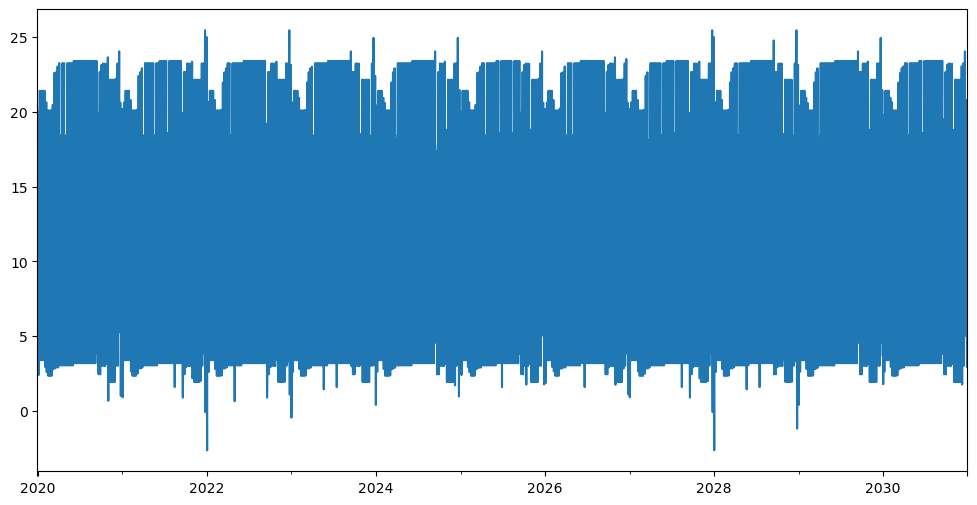

In [47]:
futuro_con_features["prediction"].plot()

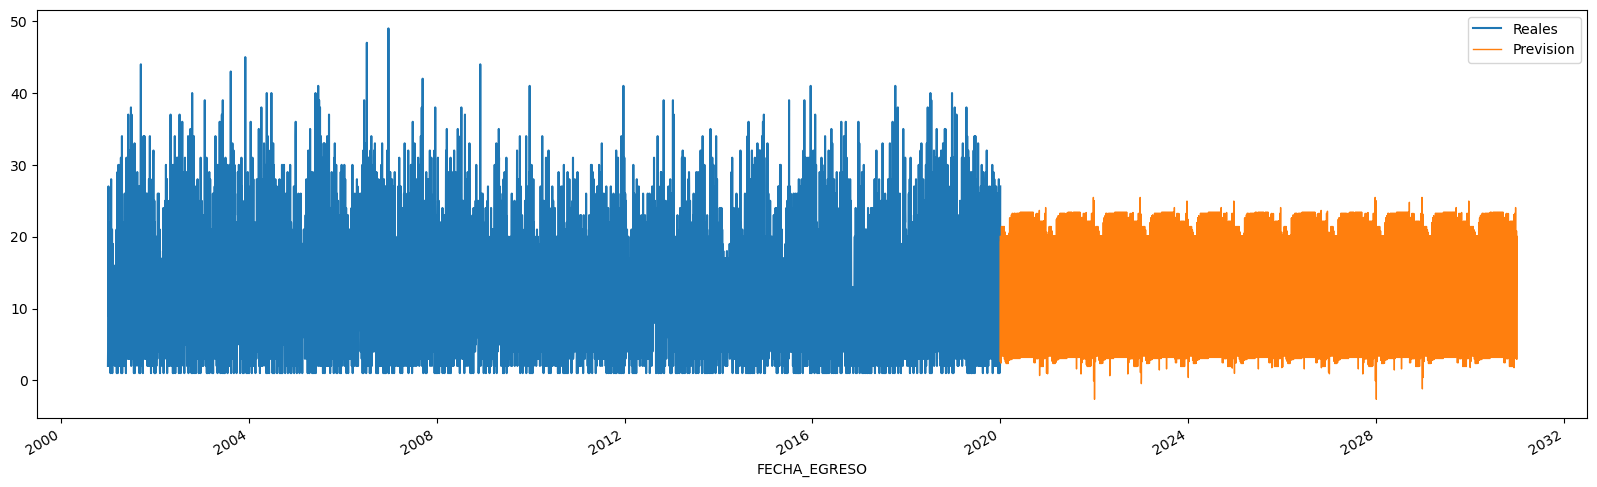

In [48]:
fig, axis = plt.subplots(1, 1, figsize=(20, 6))
resumen_egresos["n_egresos"].plot(ax=axis, label="Reales")
futuro_con_features["prediction"].plot(ax=axis, ms=1, lw=1, label="Prevision")
plt.legend()

# 2. Predicción de Insumos necesarios para el Hospital

En este apartado se quiere hacer una predicción de los insumos necesarios para el nuevo hospital,
teniendo en cuenta la demanda vista entre los años 2019, 2020 y 2021.


In [49]:
RUTA_ARCHIVO = "../data/processed/conteo_procedimientos_por_dia_int.csv"
procedimientos_hospitalizados = pd.read_csv(RUTA_ARCHIVO)
procedimientos_hospitalizados["FECHAALTA"] = pd.to_datetime(
    procedimientos_hospitalizados["FECHAALTA"]
)

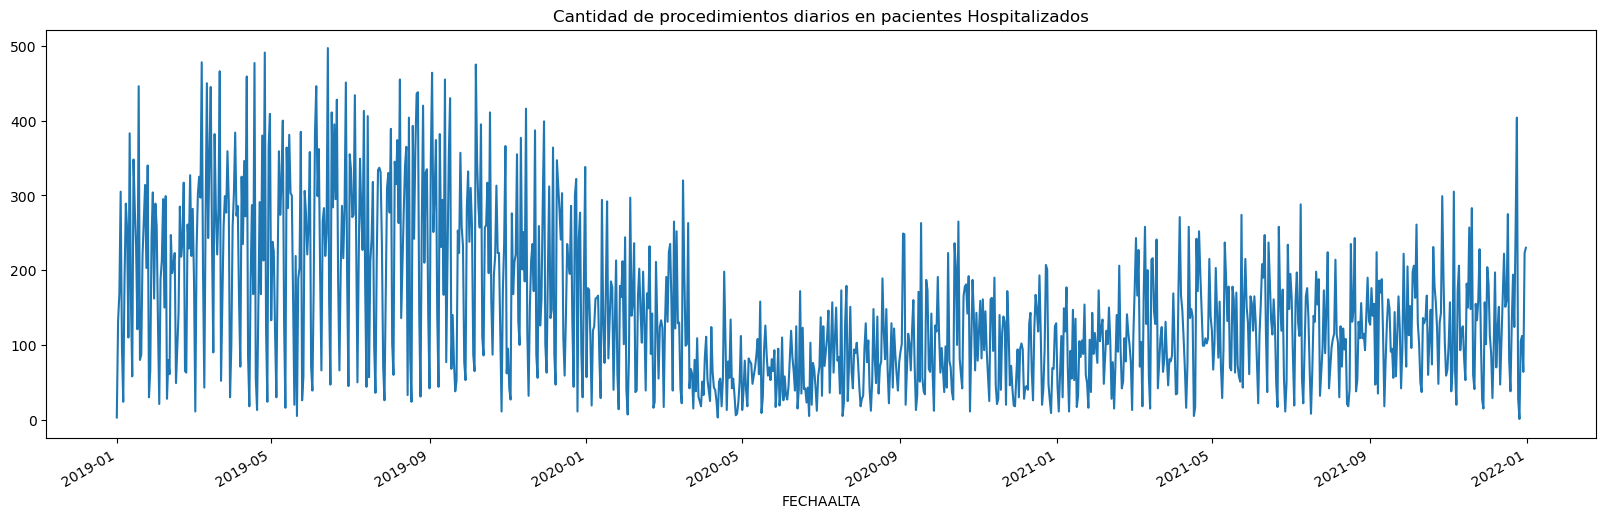

In [50]:
axis = (
    procedimientos_hospitalizados.groupby(procedimientos_hospitalizados["FECHAALTA"])["count"]
    .sum()
    .plot(title="Cantidad de procedimientos diarios en pacientes Hospitalizados", figsize=(20, 6))
)

In [51]:
df_proc = (
    procedimientos_hospitalizados.groupby(["FECHAALTA", "DIAGNOSTICO1", "procedimiento"])["count"]
    .sum()
    .reset_index(level=[1, 2])
)

df_proc = build_features.create_features_datetime_index(df_proc)

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: 

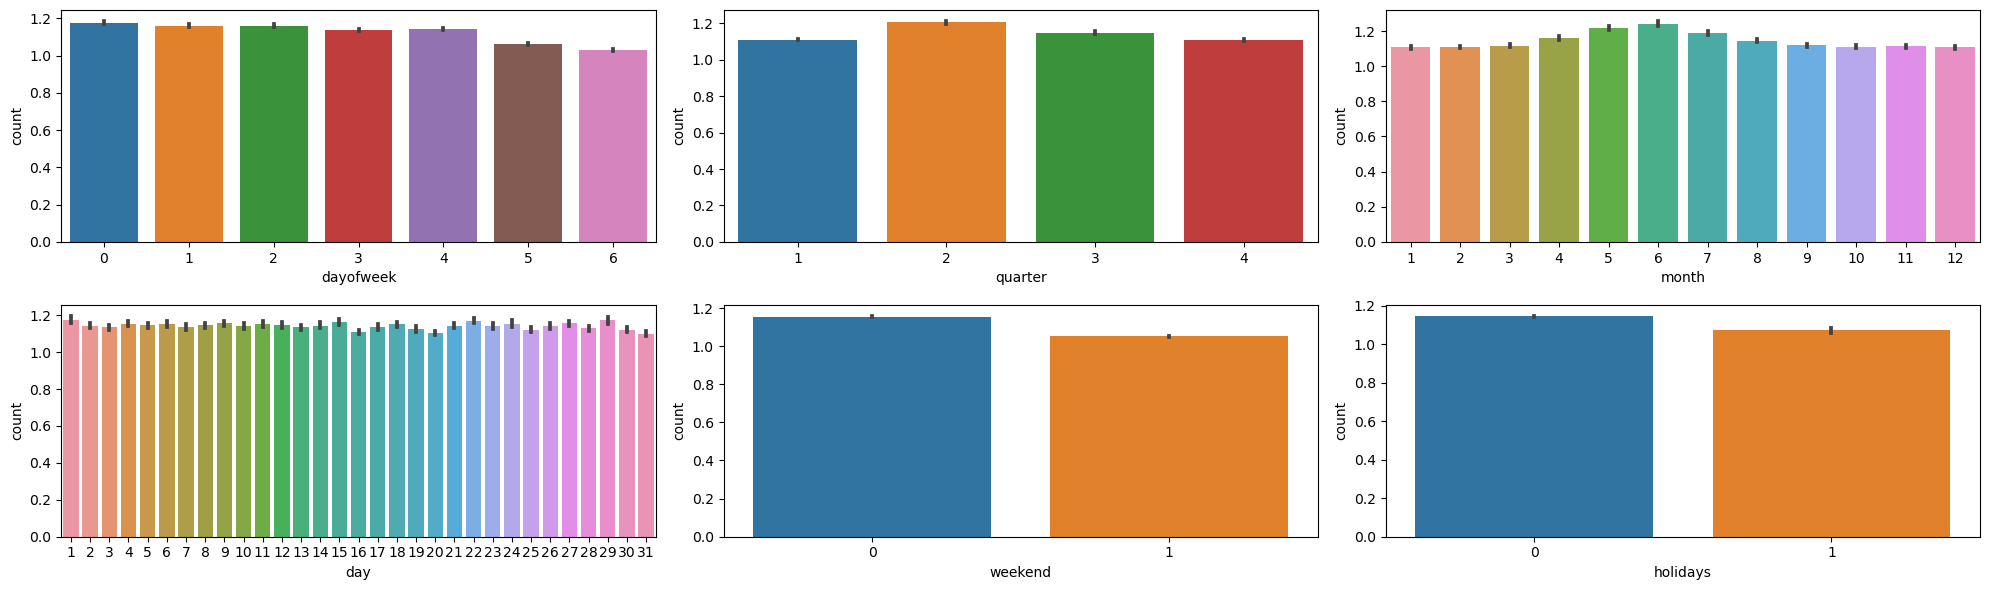

In [52]:
variables_temporales = ["dayofweek", "quarter", "month", "day", "weekend", "holidays"]

fig, axis = plt.subplots(2, 3, figsize=(20, 6))
indice_variable = 0
for i in range(2):
    for j in range(3):
        sns.barplot(data=df_proc, x=variables_temporales[indice_variable], y="count", ax=axis[i, j])
        indice_variable += 1

plt.tight_layout()
plt.show()

Los resultados indican lo siguiente:

- Durante la semana, la cantidad de procedimientos realizados disminuye a lo largo de la semana,
teniendo una máxima los Lunes (0) y un mínimo los Domingos (6)

- Dentro de los cuatrimestres, se ve que el segundo cuatrimestre es en donde se realizan la mayor
cantidad de procedimientos.

- Dentro de los meses, se observa que Abril, Mayo, Junio (máximo), Julio y Agosto tienen la mayor
demanda de procedimientos.

- Durante un mes, se ve una demanda similar entre cada dia. Sin embargo, se puede ver una leve
disminucion entre los dias 16 a 20, y 30 a 31.

- Se observa una mayor demanda en la semana que en los fin de semana.

- Se observa una menor demanada en los feriados que en los dias sin feriado.

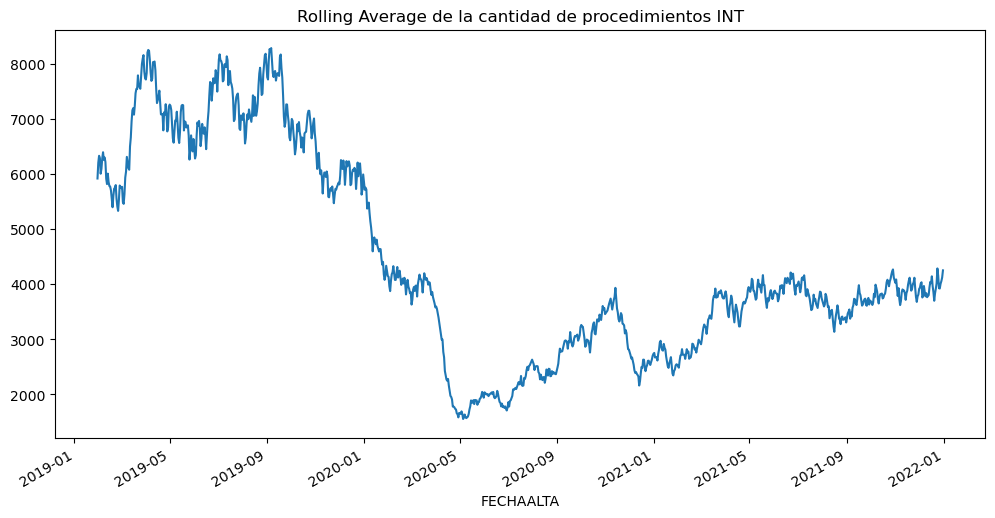

In [53]:
axis = (
    procedimientos_hospitalizados.groupby(procedimientos_hospitalizados["FECHAALTA"])["count"]
    .sum()
    .rolling(30)
    .sum()
    .plot(title="Rolling Average de la cantidad de procedimientos INT")
)

Al graficar el promedio movible (30 días) se observa que en 2019 hubo una mayor cantidad de procedimientos
que en 2020 y 2021.